In [1]:


import tweepy
from tweepy import OAuthHandler 
import re
from textblob import TextBlob
import mysql.connector
from mysql.connector import Error
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
from better_profanity import profanity
import seaborn as sns

# Twitter API credentials
consumer_key=''
consumer_secret=''
access_token=''
access_secret=''

# Authenticate with Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

# Check if the connection was successful
if api.verify_credentials():
    print("Connected to the Twitter API")
else:
    print("Error connecting to the Twitter API")

# Database credentials
db_host = "localhost"
db_name = "twitter sentiment analysis"
db_user = "root"
db_password = "root"

Connected to the Twitter API


In [2]:
# Connect to the database and create the table for storing tweets
try:
    connection = mysql.connector.connect(
        host=db_host,
        database=db_name,
        user=db_user,
        password=db_password
    )
    cursor = connection.cursor()
    create_table_query = '''CREATE TABLE IF NOT EXISTS tweets (
        id INT AUTO_INCREMENT PRIMARY KEY,
        user_account VARCHAR(255),
        followers_count INT,
        tweets_count INT,
        retweets_count INT,
        tweet_text VARCHAR(1000),
        tweet_date DATETIME,
        location VARCHAR(255),
        hashtags VARCHAR(255),
        sentiment VARCHAR(255),
        country VARCHAR(255),
        category VARCHAR(255)
    )'''
    cursor.execute(create_table_query)
    connection.commit()
except Error as e:
    print("Error while connecting to MySQL", e)

In [3]:
# Create an empty list to store the tweet data
tweet_data = []

# Create an empty set to store the tweet IDs
tweet_ids = set()


In [4]:

# Define the maximum number of requests per 15-minute window
max_requests = 6000

# Define the current request count
request_count = 0

# Define the rate limit duration in seconds
rate_limit_duration = 15 * 60



# list of categories
categories =  ['blockchain technology', 'blockchain', 'artificial intelligence', 'ai','internet of things','iot' ]
# List of countries / locations 
locations = [ re.compile(r'USA'),re.compile(r'US'), re.compile(r'CA'), re.compile(r'Canada'), re.compile(r'UK')]   


# Loop through countries /  locations and search for tweets in each category
for location in locations:
    for category in categories:
        # Set country based on the location regex
        if (location == re.compile(r'US') or location == re.compile(r'USA') or location == re.compile(r'United States') or location == re.compile(r'U.S.')):
            country = 'USA'
        elif (location == re.compile(r'UK') or location == re.compile(r'GB') or location == re.compile(r'United Kingdom') or location == re.compile(r'Great Britain')):
            country = 'UK'
        elif (location == re.compile(r'CA') or location == re.compile(r'Canada') or location == re.compile(r'CANADA')):
            country = 'CA'    
            #for category in categories: 
        start_date = datetime.datetime(2023, 2, 21, 0, 0, 0)
        end_date = datetime.datetime(2023, 3, 6, 0, 0, 0)
        # Convert the dates to UTC time
        start_date_utc = start_date.strftime('%Y-%m-%d_%H:%M:%S')
        end_date_utc = end_date.strftime('%Y-%m-%d_%H:%M:%S')
        search_query = f'"{category}" -filter:retweets -place:{location} since:{start_date_utc} until:{end_date_utc}'
        tweets = tweepy.Cursor(api.search_tweets, q=search_query, lang="en", tweet_mode="extended", ).items(300)
        for tweet in tweets:
            try:
                # Extract relevant tweet data
                tweet_id = tweet.id_str
                if tweet_id in tweet_ids:
                    # Tweet already processed, skip it
                    continue
                tweet_ids.add(tweet_id)
                user_account = tweet.user.screen_name
                followers_count = tweet.user.followers_count
                tweets_count = tweet.user.statuses_count
                retweets_count = tweet.retweet_count
                tweet_text = tweet.full_text
                tweet_date = tweet.created_at
                location = tweet.user.location
                hashtags = ', '.join(re.findall(r"#(\w+)", tweet_text))[:254]

                # Clean tweet text
                # Convert all text to lowercase to ensure consistency in the text.
                tweet_text = tweet_text.lower()
                # Replace any profanity in the text with asterisks. This requires importing a third-party library called profanity.
                tweet_text = profanity.censor(tweet_text)
                # Remove mentions (e.g. "@username") from the text.
                tweet_text = re.sub("@[A-Za-z0-9_]+","", tweet_text)
                # Remove hashtags (e.g. "#hashtag") from the text.
                tweet_text = re.sub("#[A-Za-z0-9_]+","", tweet_text)
                # Remove any URLs from the text.
                tweet_text = re.sub(r'http\S+', '', tweet_text)



                # Classify tweet sentiment using TextBlob
                sentiment = TextBlob(tweet_text).sentiment.polarity
                if sentiment > 0:
                    sentiment = 'positive'
                elif sentiment == 0:
                    sentiment = 'neutral'
                else:
                    sentiment = 'negative'


                # Set category based on the category search
                if (category == 'Artificial Intelligence' or category == 'artificial intelligence' or category == 'AI' or category == 'ai'):
                    category = 'AI'
                elif (category == 'Blockchain' or category == 'Blockchain technology' or category == 'blockchain' or category == 'blockchain technology'):
                    category = 'Blockchain'
                elif (category == 'Internet of things' or category == 'internet of things' or category == 'IoT' or category == 'iot'):
                    category = 'IoT'

                 # Add the tweet data to the list
                tweet_data.append([user_account, followers_count, tweets_count, retweets_count, tweet_text, tweet_date, location, hashtags, sentiment, category, country])

                # Insert tweet data into database
                insert_query = '''INSERT INTO tweets (
                    user_account, followers_count, tweets_count, retweets_count, tweet_text, tweet_date, location, hashtags, sentiment, country, category
                ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)'''

                values = (user_account, followers_count, tweets_count, retweets_count, tweet_text, tweet_date, location, hashtags, sentiment, country, category)
                cursor.execute(insert_query, values)
                connection.commit()

                # Increment the request count
                request_count += 1

                # Pause the execution if the maximum number of requests has been reached
                if request_count >= max_requests:
                    print("Maximum number of requests reached. Pausing for 15 minutes.")
                    time.sleep(rate_limit_duration)
                    request_count = 0

            except tweepy.RateLimitError:
                print("Rate limit reached. Sleeping for 15 minutes.")
                time.sleep(rate_limit_duration)

In [5]:
# Create a DataFrame from the tweet data list
df = pd.DataFrame(tweet_data, columns=['User Account', 'Followers Count', 'Tweets Count', 'Retweets Count', 'Tweet Text', 'Tweet Date', 'Location', 'Hashtags', 'Sentiment', 'Category', 'Country'])



In [6]:
# Fetch data from the database
try:
    select_query = '''SELECT user_account, followers_count, tweets_count, retweets_count, tweet_text, tweet_date, location, hashtags, sentiment, country, category
    FROM tweets'''
    cursor.execute(select_query)
    records = cursor.fetchall()
except Error as e:
    print("Error while fetching data from MySQL", e)


In [7]:
# Convert data to Pandas dataframe
df = pd.DataFrame(records, columns=['user_account', 'followers_count', 'tweets_count', 'retweets_count', 'tweet_text', 'tweet_date', 'location', 'hashtags', 'sentiment', 'country', 'category'])
df['tweet_date'] = pd.to_datetime(df['tweet_date'])
df.shape

(15644, 11)

In [9]:
df.shape

(15644, 11)

In [10]:
# print the number of unique tweets in the new dataframe
print(f"The new dataframe has {len(df)} unique tweets.")

The new dataframe has 15644 unique tweets.


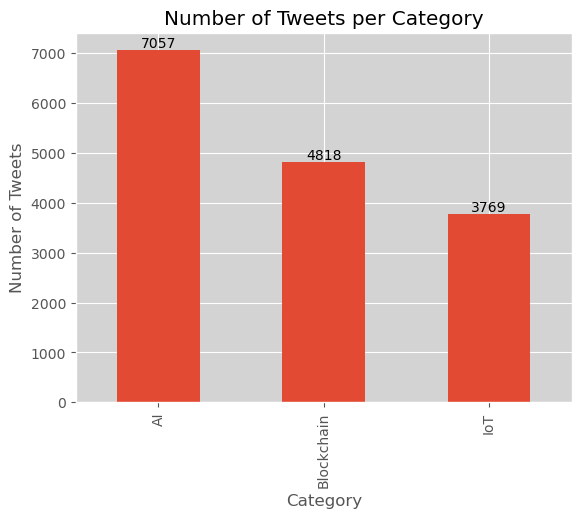

In [84]:
# Set plot background color
plt.rcParams['axes.facecolor'] = 'lightgrey'

# Get unique combinations of country and category
country_categories = df.groupby(['country', 'category']).size().reset_index()

# Create a bar plot of number of tweets per category
tweets_per_category = df.groupby('category')['tweet_text'].count()
ax = tweets_per_category.plot(kind='bar')
ax.set_title('Number of Tweets per Category')
ax.set_xlabel('Category')
ax.set_ylabel('Number of Tweets')

# Add count as text on each bar
for i, count in enumerate(tweets_per_category):
    ax.text(i, count, count, ha='center', va='bottom')

# Show the plot
plt.show()


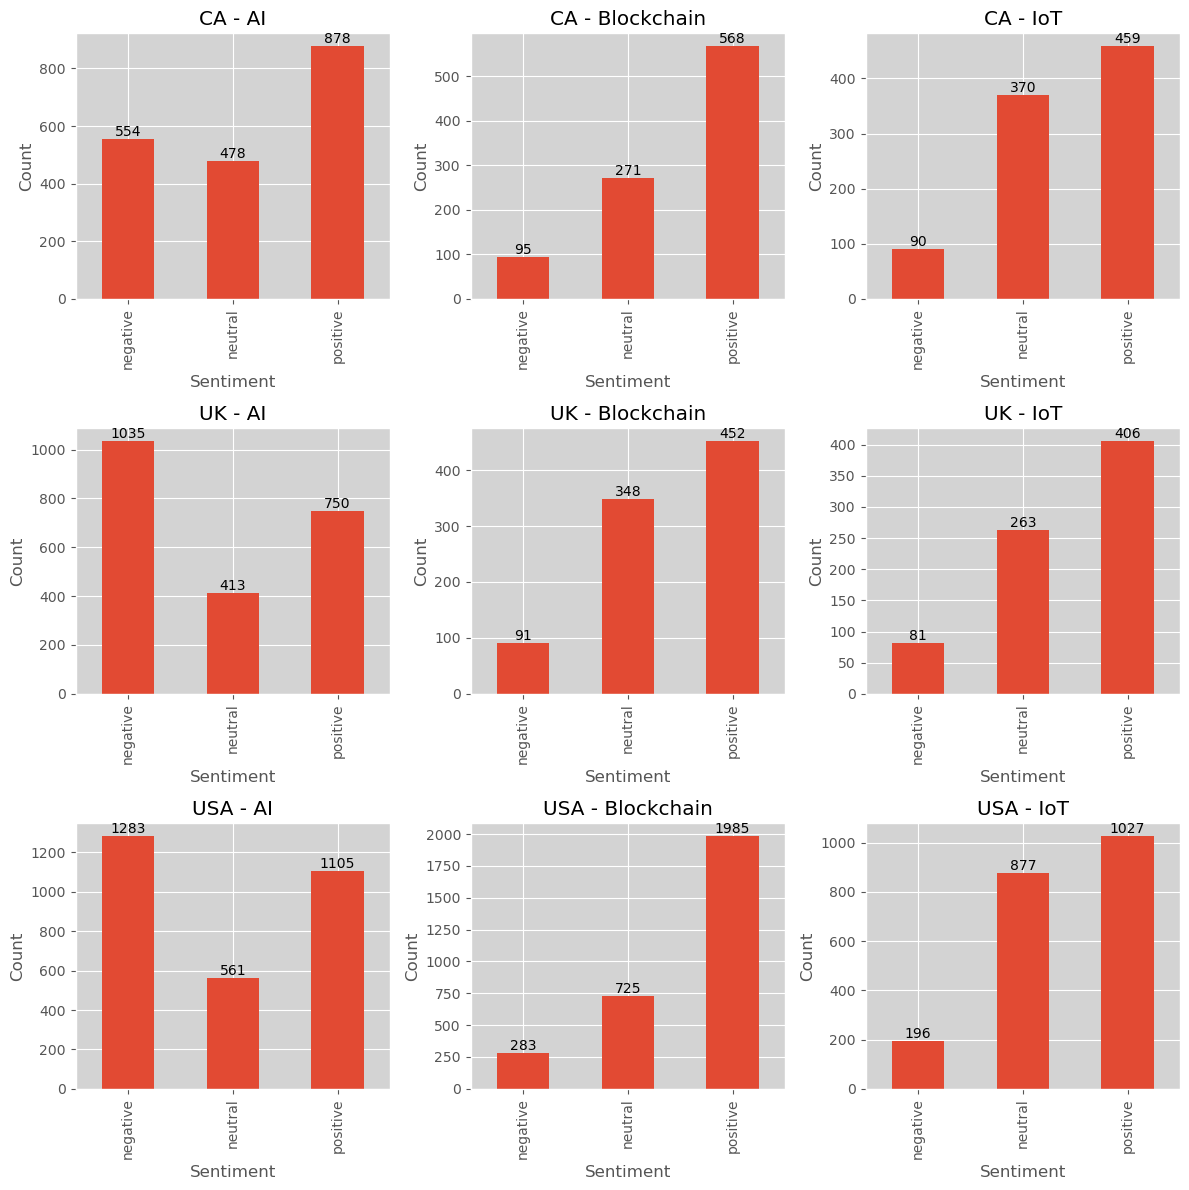

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Get unique combinations of country and category
country_categories = df.groupby(['country', 'category']).size().reset_index()
nrows, ncols = 3, 3

# Create a 3x2 subplot grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

# Loop through the combinations of country and category and plot the sentiment counts
for i, (country, category) in enumerate(country_categories[['country', 'category']].itertuples(index=False)):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    ax.set_facecolor('lightgrey') # Set the background color of the axis
    sentiment_counts = df[(df['country'] == country) & (df['category'] == category)].groupby('sentiment').size()
    sentiment_counts.plot(kind='bar', ax=ax)
    ax.set_title(f"{country} - {category}")
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Count')
    
    # Add text annotations to each bar
    for j, count in enumerate(sentiment_counts):
        ax.annotate(str(count), xy=(j, count), ha='center', va='bottom')
        
# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()


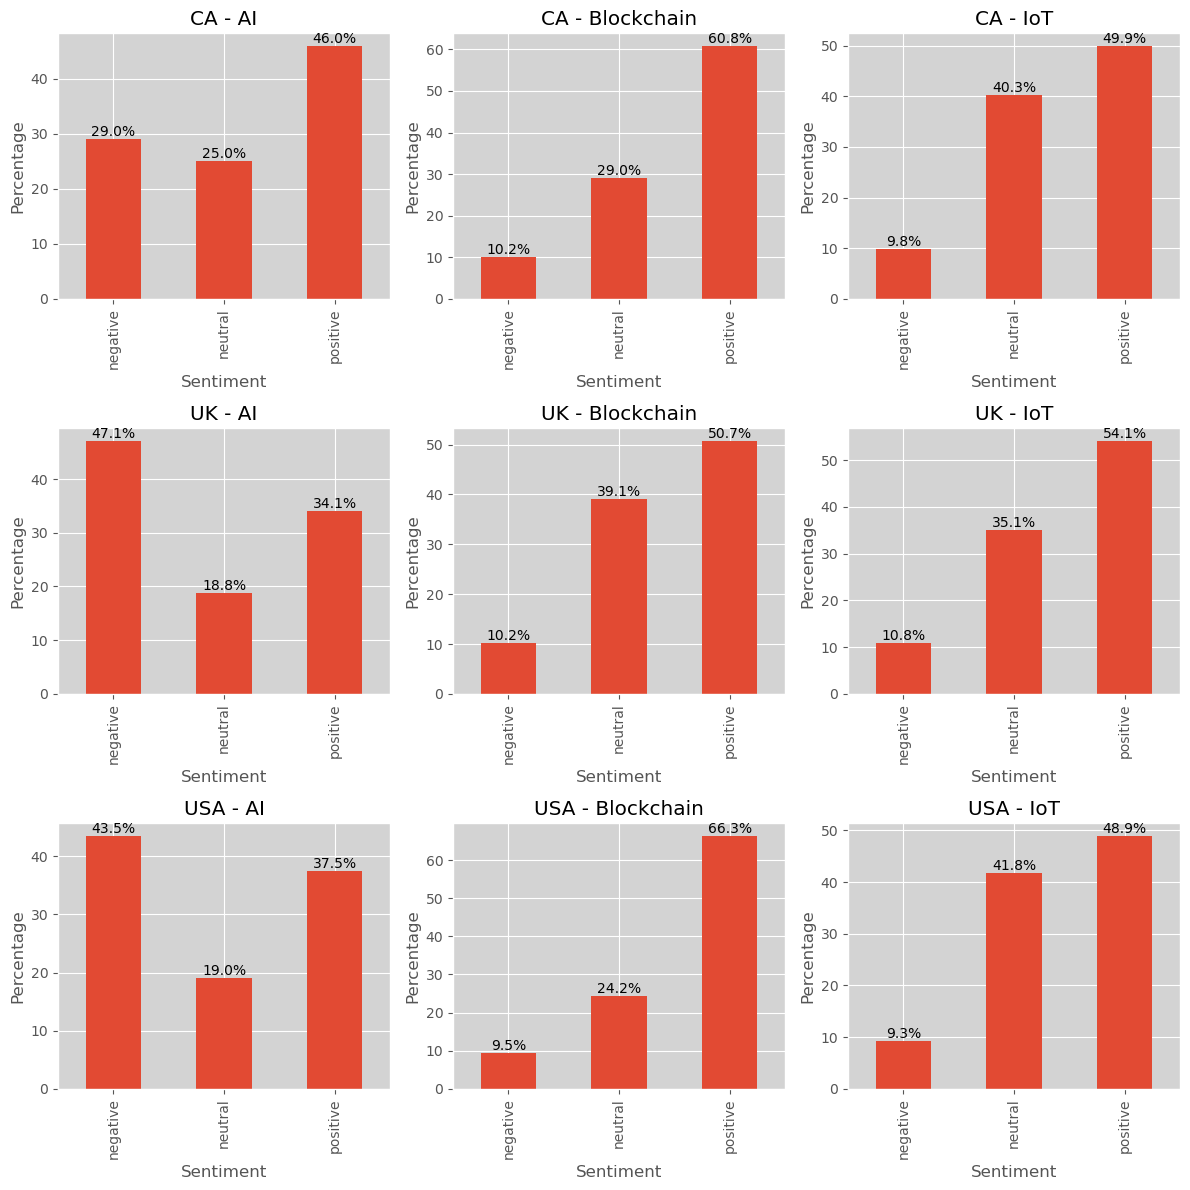

In [76]:
# Get unique combinations of country and category
country_categories = df.groupby(['country', 'category']).size().reset_index()
nrows, ncols = 3, 3

# Create a 3x2 subplot grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

# Loop through the combinations of country and category and plot the sentiment percentages
for i, (country, category) in enumerate(country_categories[['country', 'category']].itertuples(index=False)):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    ax.set_facecolor('lightgrey') 
    sentiment_counts = df[(df['country'] == country) & (df['category'] == category)].groupby('sentiment').size()
    total_tweets = sentiment_counts.sum()
    sentiment_percentages = sentiment_counts / total_tweets * 100
    sentiment_percentages.plot(kind='bar', ax=ax)  # Set color to blue
    ax.set_title(f"{country} - {category}")
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Percentage')
    # Add text annotations to each bar
    for j, pct in enumerate(sentiment_percentages):
        ax.annotate(f"{pct:.1f}%", xy=(j, pct), ha='center', va='bottom')

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()


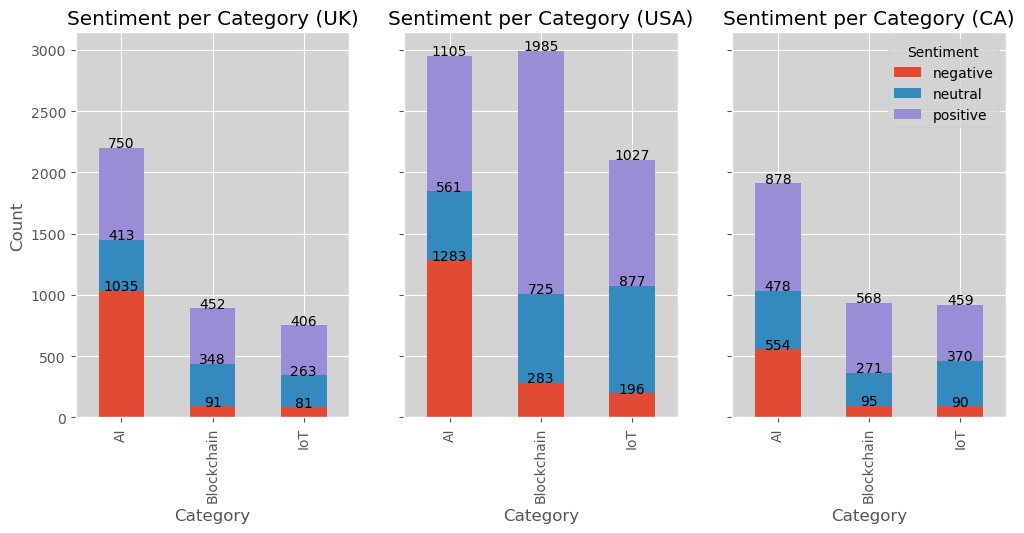

In [87]:
# Separate the data for UK, USA, and Canada
df_uk = df[df['country'] == 'UK']
df_usa = df[df['country'] == 'USA']
df_ca = df[df['country'] == 'CA']

# Group data by category and sentiment for each country
sentiment_by_category_uk = df_uk.groupby(['category', 'sentiment']).size().unstack()
sentiment_by_category_usa = df_usa.groupby(['category', 'sentiment']).size().unstack()
sentiment_by_category_ca = df_ca.groupby(['category', 'sentiment']).size().unstack()

plt.rcParams['axes.facecolor'] = 'lightgrey'

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

# Plot the barplots for UK, USA, and Canada
sentiment_by_category_uk.plot(kind='bar', stacked=True, ax=ax1, legend=False)
sentiment_by_category_usa.plot(kind='bar', stacked=True, ax=ax2, legend=False)
sentiment_by_category_ca.plot(kind='bar', stacked=True, ax=ax3)

# Set titles, labels, and the legend for the last subplot
ax1.set_title('Sentiment per Category (UK)')
ax1.set_xlabel('Category')
ax1.set_ylabel('Count')

ax2.set_title('Sentiment per Category (USA)')
ax2.set_xlabel('Category')

ax3.set_title('Sentiment per Category (CA)')
ax3.set_xlabel('Category')
ax3.legend(title='Sentiment', loc='upper right')

# Add text annotations to each bar
for ax in [ax1, ax2, ax3]:
    for i, rect in enumerate(ax.patches):
        x = rect.get_x() + rect.get_width() / 2
        y = rect.get_y() + rect.get_height() + 5
        count = int(rect.get_height())
        ax.annotate(count, xy=(x, y), ha='center', fontsize=10)

plt.show()

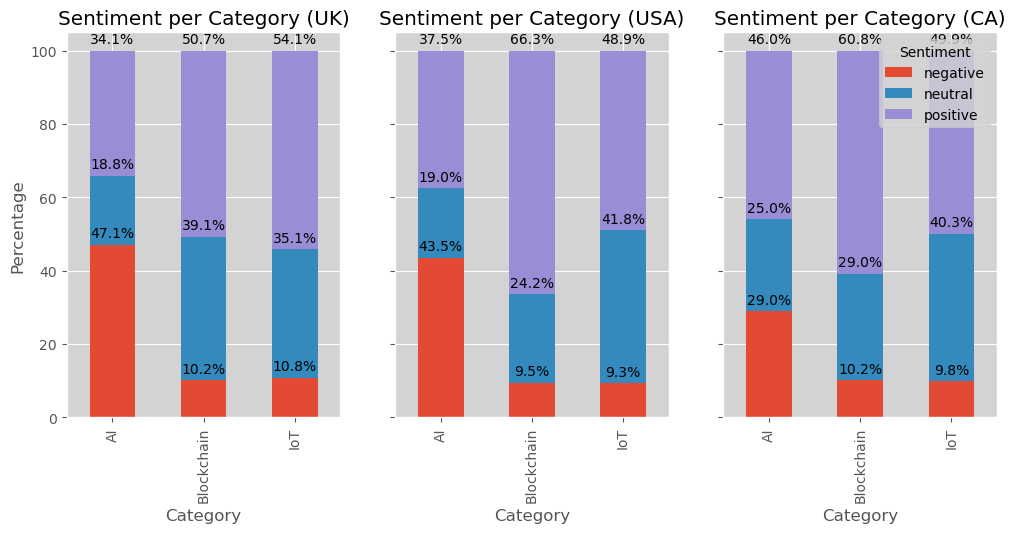

In [97]:
# Separate the data for UK, USA, and Canada
df_uk = df[df['country'] == 'UK']
df_usa = df[df['country'] == 'USA']
df_ca = df[df['country'] == 'CA']

# Group data by category and sentiment for each country
sentiment_by_category_uk = df_uk.groupby(['category', 'sentiment']).size().unstack()
sentiment_by_category_usa = df_usa.groupby(['category', 'sentiment']).size().unstack()
sentiment_by_category_ca = df_ca.groupby(['category', 'sentiment']).size().unstack()

# Convert counts to percentages
sentiment_by_category_uk = sentiment_by_category_uk.div(sentiment_by_category_uk.sum(axis=1), axis=0) * 100
sentiment_by_category_usa = sentiment_by_category_usa.div(sentiment_by_category_usa.sum(axis=1), axis=0) * 100
sentiment_by_category_ca = sentiment_by_category_ca.div(sentiment_by_category_ca.sum(axis=1), axis=0) * 100

plt.rcParams['axes.facecolor'] = 'lightgrey'

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

# Plot the barplots for UK, USA, and Canada
sentiment_by_category_uk.plot(kind='bar', stacked=True, ax=ax1, legend=False)
sentiment_by_category_usa.plot(kind='bar', stacked=True, ax=ax2, legend=False)
sentiment_by_category_ca.plot(kind='bar', stacked=True, ax=ax3)

# Set titles, labels, and the legend for the last subplot
ax1.set_title('Sentiment per Category (UK)')
ax1.set_xlabel('Category')
ax1.set_ylabel('Percentage')

ax2.set_title('Sentiment per Category (USA)')
ax2.set_xlabel('Category')

ax3.set_title('Sentiment per Category (CA)')
ax3.set_xlabel('Category')
ax3.legend(title='Sentiment', loc='upper right')

# Add text annotations to each bar
for ax in [ax1, ax2, ax3]:
    for i, rect in enumerate(ax.patches):
        x = rect.get_x() + rect.get_width() / 2
        y = rect.get_y() + rect.get_height() + 2
        percentage = '{:.1f}%'.format(rect.get_height())
        ax.annotate(percentage, xy=(x, y), ha='center', fontsize=10)

plt.show()


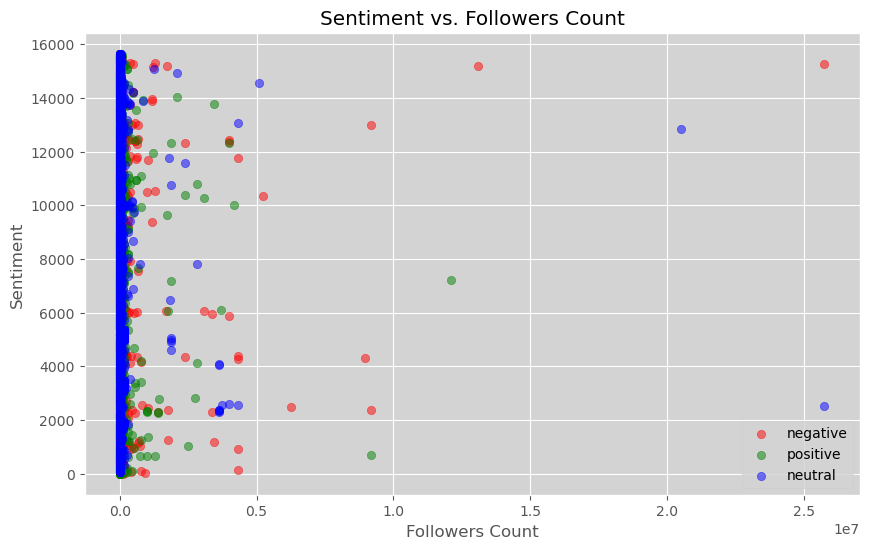

In [49]:
# Scatter plot to visualize the sentiment and followers count
fig, ax = plt.subplots(figsize=(10,6))
colors = {'positive':'green', 'negative':'red', 'neutral':'blue'}
for sentiment in df['sentiment'].unique():
    subset = df[df['sentiment']==sentiment]
    ax.scatter(subset['followers_count'], subset.index, c=colors[sentiment], label=sentiment, alpha=0.5)

# Add labels and legend
ax.set_title('Sentiment vs. Followers Count')
ax.set_xlabel('Followers Count')
ax.set_ylabel('Sentiment')
ax.legend()
plt.show()


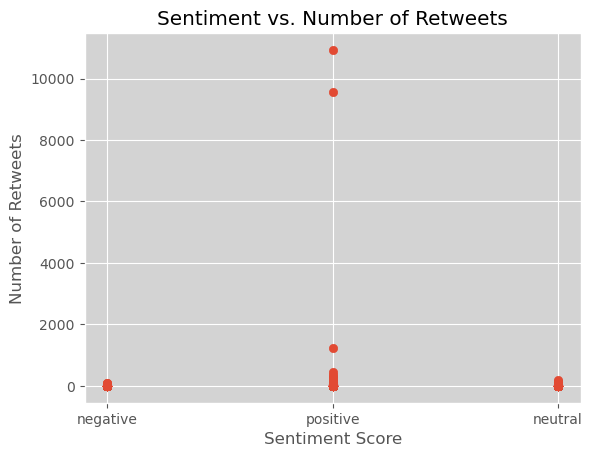

In [52]:
plt.rcParams['axes.facecolor'] = 'lightgrey'

plt.scatter(df['sentiment'], df['retweets_count'])
plt.title('Sentiment vs. Number of Retweets')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Retweets')
plt.show()

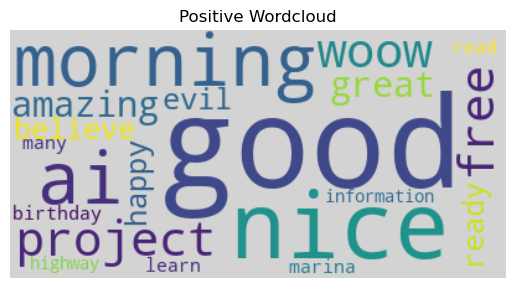

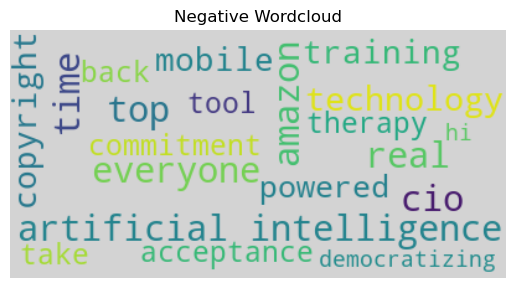

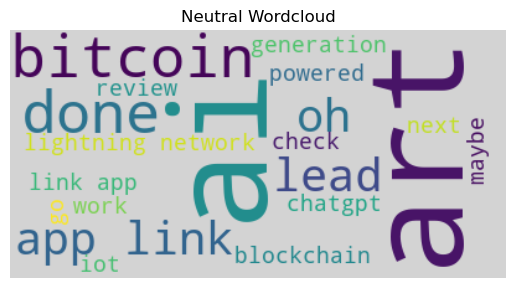

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Define list of words to exclude from wordclouds
exclude_words = ['canada', 'john', 'ca', 'join', 'us', 'will', 'u', 'week', 's', 'love']

# Define function to generate wordclouds
def generate_wordcloud(sentiment):
    # Join all tweet texts for given sentiment, excluding exclude_words
    text = ' '.join(tweet for tweet in df[df['sentiment'] == sentiment]['tweet_text'] 
                    if all(word.lower() not in tweet.lower() for word in exclude_words))
    # Generate wordcloud with most frequent words
    wordcloud = WordCloud(max_words=20, background_color="lightgrey", relative_scaling = 0.01).generate(text)
    # Plot wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(sentiment.capitalize() + " Wordcloud")
    plt.show()

# Generate wordclouds for each sentiment
generate_wordcloud('positive')
generate_wordcloud('negative')
generate_wordcloud('neutral')

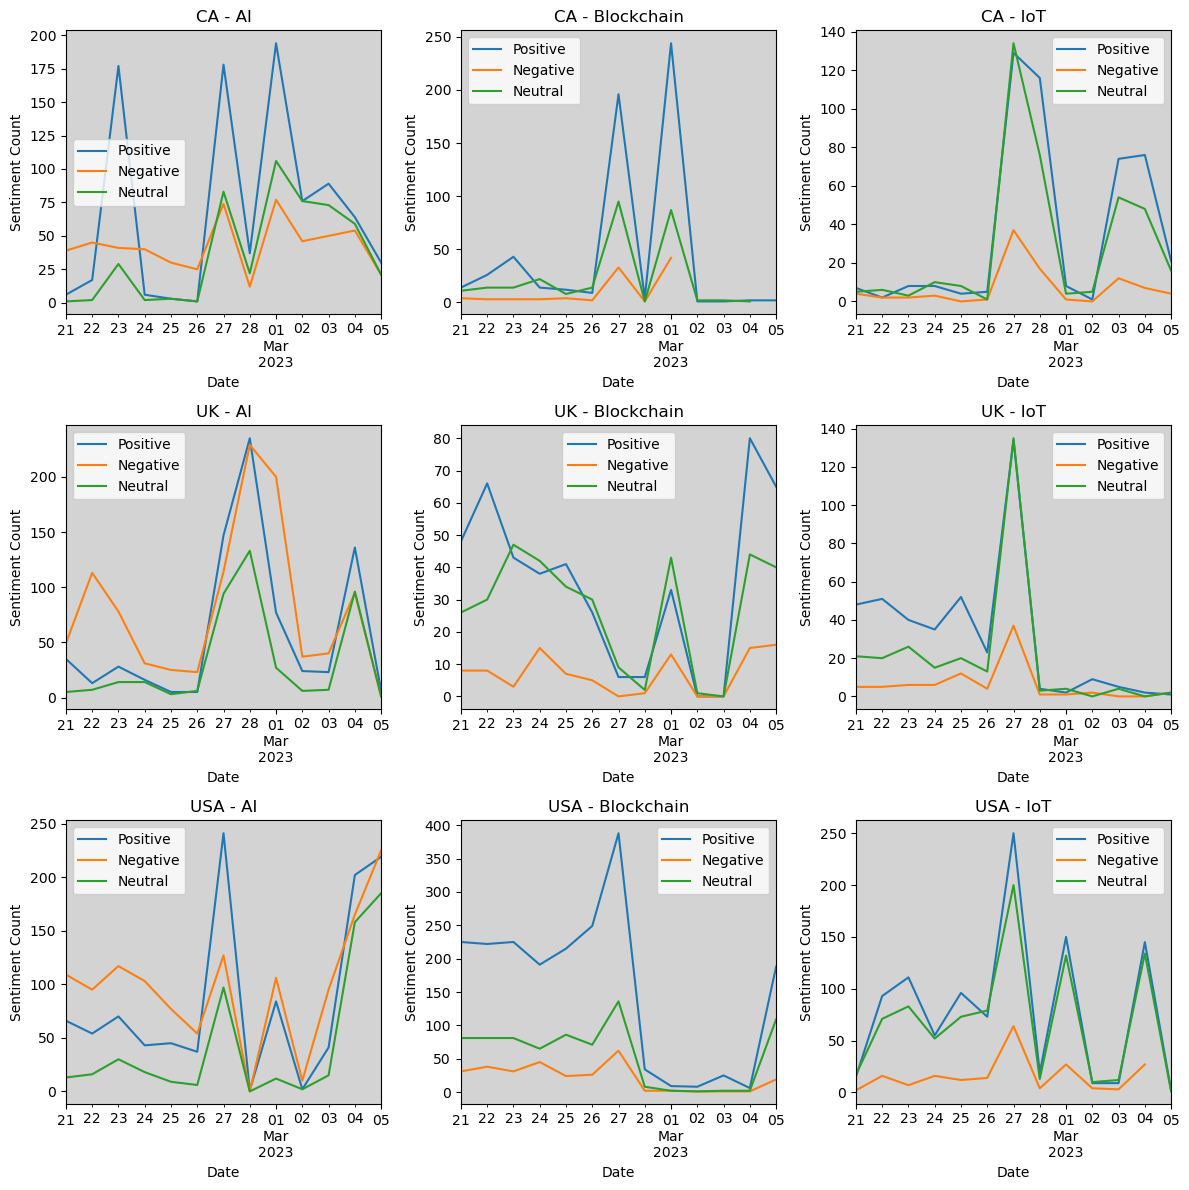

In [35]:

# Convert data to Pandas dataframe
df = pd.DataFrame(records, columns=['user_account', 'followers_count', 'tweets_count', 'retweets_count', 'tweet_text', 'tweet_date', 'location', 'hashtags', 'sentiment', 'country', 'category'])
df['tweet_date'] = pd.to_datetime(df['tweet_date'])

# Get unique combinations of country and category
country_categories = df.groupby(['country', 'category']).size().reset_index()
nrows, ncols = 3, 3

# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

# Loop through the combinations of country and category and plot the sentiment counts by day
for i, (country, category) in enumerate(country_categories[['country', 'category']].itertuples(index=False)):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    ax.set_facecolor('lightgray') # Set gray background color for subplot
    for sentiment in ['positive', 'negative', 'neutral']:
        sentiment_counts = df[(df['country'] == country) & (df['category'] == category) & (df['sentiment'] == sentiment)].groupby(pd.Grouper(key='tweet_date', freq='D')).size()
        sentiment_counts.plot(kind='line', ax=ax, label=sentiment.title())
    ax.set_title(f"{country} - {category}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment Count')
    ax.legend()
    
# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()


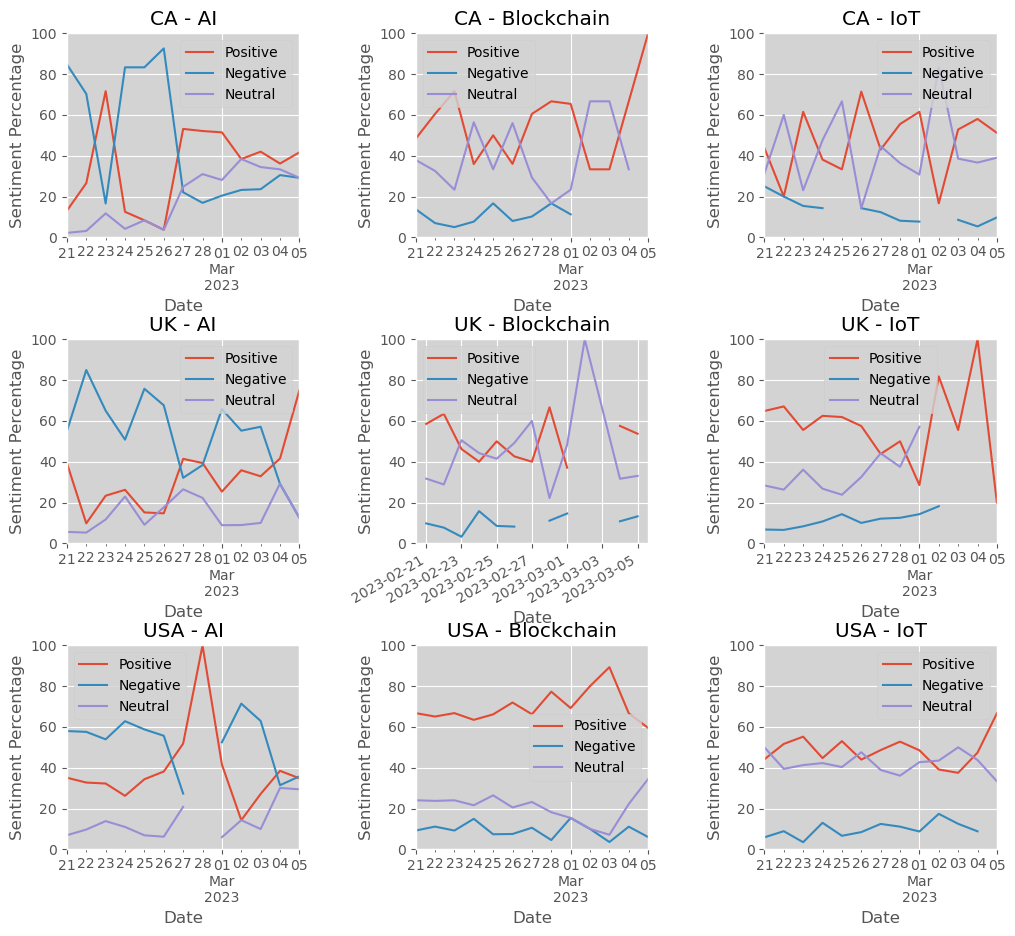

In [90]:
# Create a 3x3 subplot grid with wider spaces and gray background
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for ax in axes.flatten():
    ax.set_facecolor('lightgray')

for i, (country, category) in enumerate(country_categories[['country', 'category']].itertuples(index=False)):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    sentiment_counts = df[(df['country'] == country) & (df['category'] == category)].groupby(['sentiment', pd.Grouper(key='tweet_date', freq='D')]).size()
    total_counts = sentiment_counts.groupby(level=1).sum() # get the total count by day
    for sentiment in ['positive', 'negative', 'neutral']:
        sentiment_percentages = sentiment_counts.loc[sentiment] / total_counts * 100 # Calculate the percentage of the sentiment count for each day
        sentiment_percentages.plot(kind='line', ax=ax, label=sentiment.title())
    ax.set_title(f"{country} - {category}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment Percentage')
    ax.set_ylim([0, 100])
    ax.legend()


In [91]:
# Group data by sentiment and date
grouped = df.groupby(['sentiment', pd.Grouper(key='tweet_date', freq='D')]).size().unstack(fill_value=0)

In [92]:
# Calculate weighted sentiment score based on number of followers and retweets
df['weighted_sentiment'] = df['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1}) * (df['followers_count'] + df['retweets_count'])


<AxesSubplot:xlabel='country', ylabel='category'>

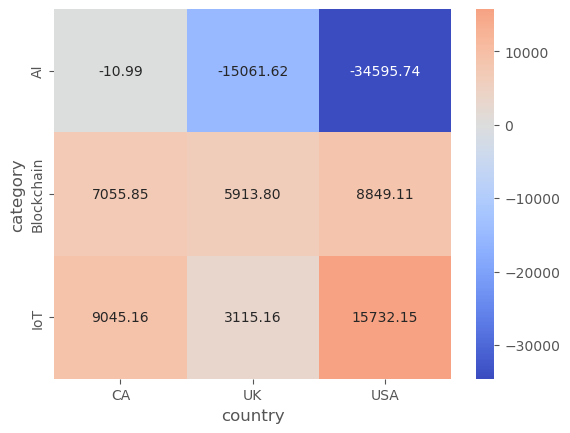

In [93]:
# Heatmap of weighted sentiment by country and category: This can show how the sentiment varies across different categories and countries. 

heatmap_data = df.pivot_table(index='category', columns='country', values='weighted_sentiment')
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.2f', center=0)


In [94]:
# Close database connection
connection.close()